In [23]:
# Import des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import duckdb
import requests
from tqdm import tqdm
import seaborn as sns
import os
from shapely.geometry import shape

In [18]:
# Téléchargement des fichiers (s'ils ne sont pas déjà enregistrés) et affichage d'une barre de progression
def download_file(url: str, filename: str) -> None:
    try:
        # Envoyer une requête GET à l'URL
        response = requests.get(url, stream=True)
        
        # Vérifier si la requête a réussi
        response.raise_for_status()
        
        # Récupérer la taille totale du fichier depuis les headers (si disponible)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kilobyte

        # Afficher un message si le content-length n'est pas disponible
        if total_size == 0:
            print(f"Impossible de déterminer la taille du fichier {filename}, téléchargement sans barre de progression.")
        
        # Configuration de la barre de progression
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=filename) if total_size > 0 else None
        
        # Écrire le contenu dans le fichier
        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=block_size):
                if progress_bar:
                    progress_bar.update(len(chunk))
                file.write(chunk)
        
        if progress_bar:
            progress_bar.close()
        print(f"Fichier téléchargé avec succès: {filename}")
    
    except requests.exceptions.RequestException as e:
        print(f"Le téléchargement a échoué: {e}")

# Liste des URLs avec les noms personnalisés des fichiers à télécharger
files_to_download = {
    "logements": {"url": "https://static.data.gouv.fr/resources/recensement-de-la-population-fichiers-detail-logements-ordinaires-en-2020-1/20231023-123618/fd-logemt-2020.parquet", "filename": "RP_logements_2020.parquet"},
    "individus": {"url": "https://static.data.gouv.fr/resources/recensement-de-la-population-fichiers-detail-individus-localises-au-canton-ou-ville-2020-1/20231023-122841/fd-indcvi-2020.parquet", "filename": "RP_individus_2020.parquet"},
    "documentation_logement": {"url": "https://www.data.gouv.fr/fr/datasets/r/c274705f-98db-4d9b-9674-578e04f03198", "filename": "Dictionnaire_RP_logements_2020.csv"},
    "documentation_individus": {"url": "https://www.data.gouv.fr/fr/datasets/r/1c6c6ab2-b766-41a4-90f0-043173d5e9d1", "filename": "Dictionnaire_RP_individus_2020.csv"},
    "table_bpe": {"url": "https://www.insee.fr/fr/statistiques/fichier/8217525/BPE23.parquet", "filename": "BPE_2023.parquet"}
}

# Boucle pour télécharger les fichiers avec des noms personnalisés (s'ils ne sont pas déjà enregistrés)
for key, file_info in files_to_download.items():
    url = file_info["url"]
    filename = file_info["filename"]
    
    # Débogage : vérifier si le fichier existe déjà
    if os.path.exists(filename):
        print(f"Le fichier {filename} existe déjà, pas de téléchargement.")
    else:
        print(f"Téléchargement de {filename}...")
        download_file(url, filename)


Téléchargement de RP_logements_2020.parquet...


RP_logements_2020.parquet: 100%|██████████| 504M/504M [00:14<00:00, 35.7MiB/s] 


Fichier téléchargé avec succès: RP_logements_2020.parquet
Téléchargement de RP_individus_2020.parquet...


RP_individus_2020.parquet: 100%|██████████| 533M/533M [00:22<00:00, 23.8MiB/s] 


Fichier téléchargé avec succès: RP_individus_2020.parquet
Téléchargement de Dictionnaire_RP_logements_2020.csv...
Impossible de déterminer la taille du fichier Dictionnaire_RP_logements_2020.csv, téléchargement sans barre de progression.
Fichier téléchargé avec succès: Dictionnaire_RP_logements_2020.csv
Téléchargement de Dictionnaire_RP_individus_2020.csv...
Impossible de déterminer la taille du fichier Dictionnaire_RP_individus_2020.csv, téléchargement sans barre de progression.
Fichier téléchargé avec succès: Dictionnaire_RP_individus_2020.csv
Le fichier BPE_2023.parquet existe déjà, pas de téléchargement.


In [20]:
# Connexion à DuckDB (les tables seront stockées dans la RAM)
con = duckdb.connect()

# Chargement des tables dans (et donc accessibles via) DuckDB
con.execute("""
    CREATE OR REPLACE VIEW table_logement AS 
    SELECT * FROM read_parquet('RP_logements_2020.parquet')
""")
con.execute("""
    CREATE OR REPLACE VIEW table_individu AS 
    SELECT * FROM read_parquet('RP_individus_2020.parquet')
""")

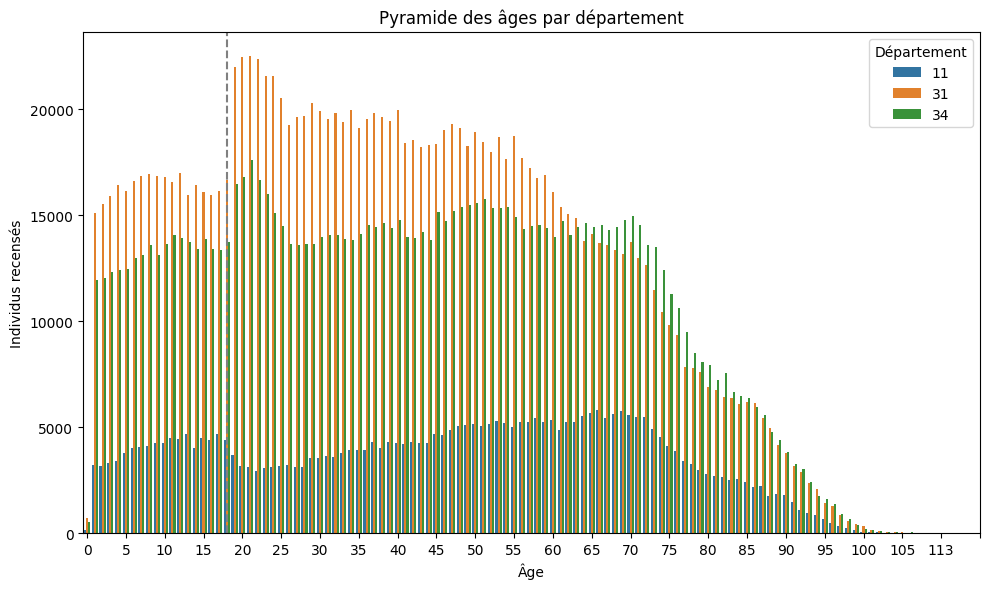

In [24]:
# Requête SQL pour obtenir les données de la pyramide des âges
query = """
    SELECT AGED, DEPT AS departement, SUM(IPONDI) AS individus
    FROM table_individu
    WHERE DEPT IN ('11', '31', '34')
    GROUP BY AGED, DEPT
    ORDER BY DEPT, AGED
"""

# Exécuter la requête via DuckDB et collecter les résultats dans un DataFrame pandas
pyramide_ages = con.execute(query).df()

# Visualisation avec matplotlib et seaborn (équivalent ggplot2)
plt.figure(figsize=(10, 6))
sns.barplot(data=pyramide_ages, x='AGED', y='individus', hue='departement')

# Ajouter une ligne verticale pour marquer l'âge de 18 ans
plt.axvline(x=18, color='grey', linestyle='--')

# Modifier les labels de l'axe des x pour qu'ils apparaissent tous les 5 ans
age_ticks = range(0, pyramide_ages['AGED'].max() + 1, 5)  # Intervalles de 5 ans
plt.xticks(ticks=age_ticks)

# Paramètres de la figure
plt.title("Pyramide des âges par département")
plt.xlabel("Âge")
plt.ylabel("Individus recensés")
plt.legend(title="Département")
plt.tight_layout()

# Afficher la figure
plt.show()
